# Movie Analysis

## Business Problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.


#### Import the required libraries

In [114]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as psql
from pandasql import sqldf
import sqlite3
from scipy.stats import norm, stats, ttest_1samp, zscore
import matplotlib.pyplot as plt
%matplotlib inline

### Extract the data from the box office gross dataset

In [115]:
bom_gross_data = pd.read_csv('./zippedData/bom.movie_gross.csv.gz', header=0)
bom_gross_data.head(10)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010
6,Iron Man 2,Par.,312400000.0,311500000,2010
7,Tangled,BV,200800000.0,391000000,2010
8,Despicable Me,Uni.,251500000.0,291600000,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000,2010


In [116]:
bom_gross_data.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [117]:
bom_gross_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### Extract the data from the imdb database using SQLite

In [118]:
# Connect to the SQLite database
conn = sqlite3.connect('./zippedData/im.db/im.db')

# Load tables into DataFrames
movie_basics_df = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
directors_df = pd.read_sql_query("SELECT * FROM directors;", conn)
known_for_df = pd.read_sql_query("SELECT * FROM known_for;", conn)
movie_akas_df = pd.read_sql_query("SELECT * FROM movie_akas;", conn)
movie_ratings_df = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)
persons_df = pd.read_sql_query("SELECT * FROM persons;", conn)
principals_df = pd.read_sql_query("SELECT * FROM principals;", conn)
writers_df = pd.read_sql_query("SELECT * FROM writers;", conn)

# Close the connection
conn.close()


In [119]:
# lambda function to simplify SQL querying
pysqldf = lambda q: sqldf(q, globals())


In [120]:
#test query
query1 = """SELECT * FROM movie_basics_df
            WHERE start_year > 2015"""
result1 = pysqldf(query1)
# print(result1)
result1


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
1,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
2,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
3,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
4,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
...,...,...,...,...,...,...
61062,tt9916186,Illenau - die Geschichte einer ehemaligen Heil...,Illenau - die Geschichte einer ehemaligen Heil...,2017,84.0,Documentary
61063,tt9916190,Safeguard,Safeguard,2019,90.0,"Drama,Thriller"
61064,tt9916428,The Secret of China,The Secret of China,2019,NaN,"Adventure,History,War"
61065,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama


In [121]:
#Read the numbers csv
numbers_df = pd.read_csv('./zippedData/tn.movie_budgets.csv/tn.movie_budgets.csv')
numbers_df.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [122]:
rt_movie_df = pd.read_csv('./zippedData/rt.movie_info.tsv/rt.movie_info.tsv', sep='\t', header=0)
rt_movie_df.head(10)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN
9,15,When a diamond expedition in the Congo is lost...,PG-13,Action and Adventure|Mystery and Suspense|Scie...,Frank Marshall,John Patrick Shanley,"Jun 9, 1995","Jul 27, 1999",NaN,NaN,108 minutes,NaN


In [123]:
# Function that will save any df to a certain specified directory
def save_df_to_directory(df, directory, filename):
    """
    Saves a DataFrame to a specified directory with the given file name.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    directory (str): The directory where the DataFrame will be saved.
    file_name (str): The name of the file to save the DataFrame as.
    """
    #ensure the os exists
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    #create the full path
    file_path = os.path.join(directory, filename)

    #save the dataframe as a csv file
    df.to_csv(file_path, index="False")

In [124]:
save_df_to_directory(rt_movie_df, './accessible_data/', 'rt_numbers.csv')

In [125]:
save_df_to_directory(movie_basics_df, './accessible_data/', 'movie_basics_df.csv')

In [126]:
movie_ratings_df.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [127]:
save_df_to_directory(movie_ratings_df, './accessible_data/', 'movie_ratings_df.csv')

In [128]:
save_df_to_directory(numbers_df, './accessible_data/', 'production_numbers.csv')

In [129]:
print('Movie Basic DF')
print(movie_basics_df.describe())
print()
print('Box office gross dataframe')
print(bom_gross_data.describe())

Movie Basic DF
          start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000

Box office gross dataframe
       domestic_gross         year
count    3.359000e+03  3387.000000
mean     2.874585e+07  2013.958075
std      6.698250e+07     2.478141
min      1.000000e+02  2010.000000
25%      1.200000e+05  2012.000000
50%      1.400000e+06  2014.000000
75%      2.790000e+07  2016.000000
max      9.367000e+08  2018.000000


In [130]:
save_df_to_directory(bom_gross_data,'./accessible_data/', 'bom_gross_df.csv')


In [131]:
#identify missing values in bom_gross_data
bom_gross_data.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [132]:
#identify missing values in movie_ratings_df
movie_ratings_df.isnull().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

In [133]:
#identify missing values in movie_basics_df
movie_basics_df.isnull().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

##### Merge  dataframes 

To start, we will merge the box office df and the movie basic

In [134]:
# Remove leading/trailing spaces, and convert relevant columns to numeric values
bom_gross_data.columns = bom_gross_data.columns.str.strip()
numbers_df.columns = numbers_df.columns.str.strip()

In [135]:
# Merge the dataframes on the movie title
# First, merge the first two DataFrames on the title
df_merged = pd.merge(bom_gross_data, movie_basics_df, left_on='title', right_on='primary_title', how='left')

df_merged

,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,Toy Story 3,Toy Story 3,2010.0,103.0,"Adventure,Animation,Comedy"
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,WB,292600000.0,535700000,2010,tt1375666,Inception,Inception,2010.0,148.0,"Action,Adventure,Sci-Fi"
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010.0,93.0,"Adventure,Animation,Comedy"
...,...,...,...,...,...,...,...,...,...,...,...
4142,The Quake,Magn.,6200.0,NaN,2018,tt6523720,The Quake,Skjelvet,2018.0,106.0,"Action,Drama,Thriller"
4143,Edward II (2018 re-release),FM,4800.0,NaN,2018,NaN,NaN,NaN,NaN,NaN,NaN
4144,El Pacto,Sony,2500.0,NaN,2018,NaN,NaN,NaN,NaN,NaN,NaN
4145,The Swan,Synergetic,2400.0,NaN,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147 entries, 0 to 4146
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4147 non-null   object 
 1   studio           4142 non-null   object 
 2   domestic_gross   4112 non-null   float64
 3   foreign_gross    2516 non-null   object 
 4   year             4147 non-null   int64  
 5   movie_id         3366 non-null   object 
 6   primary_title    3366 non-null   object 
 7   original_title   3366 non-null   object 
 8   start_year       3366 non-null   float64
 9   runtime_minutes  3198 non-null   float64
 10  genres           3326 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 356.5+ KB


In [137]:
# Convert gross columns to numeric, coercing errors to NaN
df_merged['domestic_gross'] = pd.to_numeric(bom_gross_data['domestic_gross'], errors='coerce')
df_merged['foreign_gross'] = pd.to_numeric(bom_gross_data['foreign_gross'], errors='coerce')

# Fill missing values with the mean
df_merged['domestic_gross'].fillna(df_merged['domestic_gross'].mean(), inplace=True)
df_merged['foreign_gross'].fillna(df_merged['foreign_gross'].mean(), inplace=True)

df_merged

,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,Toy Story 3,BV,4.150000e+08,6.520000e+08,2010,tt0435761,Toy Story 3,Toy Story 3,2010.0,103.0,"Adventure,Animation,Comedy"
1,Alice in Wonderland (2010),BV,3.342000e+08,6.913000e+08,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,WB,2.960000e+08,6.643000e+08,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,WB,2.926000e+08,5.357000e+08,2010,tt1375666,Inception,Inception,2010.0,148.0,"Action,Adventure,Sci-Fi"
4,Shrek Forever After,P/DW,2.387000e+08,5.139000e+08,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010.0,93.0,"Adventure,Animation,Comedy"
...,...,...,...,...,...,...,...,...,...,...,...
4142,The Quake,Magn.,2.874585e+07,7.505704e+07,2018,tt6523720,The Quake,Skjelvet,2018.0,106.0,"Action,Drama,Thriller"
4143,Edward II (2018 re-release),FM,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN
4144,El Pacto,Sony,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN
4145,The Swan,Synergetic,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
save_df_to_directory(df_merged, './accessible_data/', 'bom_basics_merged_df.csv')

In [139]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147 entries, 0 to 4146
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4147 non-null   object 
 1   studio           4142 non-null   object 
 2   domestic_gross   4147 non-null   float64
 3   foreign_gross    4147 non-null   float64
 4   year             4147 non-null   int64  
 5   movie_id         3366 non-null   object 
 6   primary_title    3366 non-null   object 
 7   original_title   3366 non-null   object 
 8   start_year       3366 non-null   float64
 9   runtime_minutes  3198 non-null   float64
 10  genres           3326 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 356.5+ KB


In [140]:
# # Then, merge the result with the third DataFrame
synopsis_df = pd.merge(rt_movie_df, numbers_df, left_on='id', right_on='id', how='right')
synopsis_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [141]:
# Convert all object-type columns to float
# List of columns to convert
columns_to_convert = ['production_budget', 'domestic_gross','worldwide_gross']

# Replace non-numeric characters and convery to float
synopsis_df[columns_to_convert] = synopsis_df[columns_to_convert].replace({'\$': '', ',': ''}, regex=True).astype(float)

#convert to int
synopsis_df[columns_to_convert] = synopsis_df[columns_to_convert].astype(int)

In [142]:
# Descriptive analysis: Summary statistics for budgets and gross revenues
budget_gross_summary = synopsis_df[['production_budget', 'domestic_gross', 'worldwide_gross']].describe()

# Descriptive analysis: Frequency distribution of genres
# Descriptive analysis: Frequency distribution of genres
# Splitting the genres into individual genres for better analysis
genres_split = synopsis_df['genre'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
genre_counts = genres_split.value_counts()


budget_gross_summary, genre_counts.head(10)  # Show top 10 genres by frequency

(       production_budget  domestic_gross  worldwide_gross
 count       5.782000e+03    5.782000e+03     5.782000e+03
 mean        3.158776e+07    4.187333e+07     8.988256e+07
 std         4.181208e+07    6.824060e+07     1.738874e+08
 min         1.100000e+03    0.000000e+00    -2.147484e+09
 25%         5.000000e+06    1.429534e+06     4.102274e+06
 50%         1.700000e+07    1.722594e+07     2.794748e+07
 75%         4.000000e+07    5.234866e+07     9.758278e+07
 max         4.250000e+08    9.366622e+08     2.053311e+09,
 Drama                          2714
 Comedy                         1790
 Action and Adventure           1102
 Mystery and Suspense            984
 Romance                         691
 Classics                        578
 Musical and Performing Arts     519
 Art House and International     403
 Science Fiction and Fantasy     348
 Horror                          347
 Name: count, dtype: int64)

In [143]:
genres_split.name = 'genre'
merged_genres = synopsis_df.drop('genre', axis=1).join(genres_split)

In [144]:
rt_movie_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [145]:
save_df_to_directory(synopsis_df, './accessible_data/', 'synopsis.csv')

### Descriptive Breakdown

In [146]:
# Calculate total and average gross by year
gross_by_year = df_merged.groupby('year').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
).reset_index()

gross_by_year

,year,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,2010,1.810246e+10,4.536956e+07,2.839216e+10,7.115829e+07
1,2011,1.295417e+10,2.682023e+07,2.744150e+10,5.681470e+07
2,2012,1.136210e+10,2.333080e+07,3.142733e+10,6.453250e+07
3,2013,1.046567e+10,2.480016e+07,3.063419e+10,7.259286e+07
4,2014,1.108408e+10,2.353307e+07,3.607043e+10,7.658264e+07
5,2015,2.040815e+10,3.612061e+07,5.953017e+10,1.053631e+08
6,2016,1.298453e+10,2.477963e+07,3.809541e+10,7.270116e+07
7,2017,1.092445e+10,2.626071e+07,3.114870e+10,7.487669e+07
8,2018,1.092342e+10,2.874585e+07,2.852168e+10,7.505704e+07


In [147]:
# Split the genres column
df_merged.loc[df_merged.index, 'genres'] = df_merged['genres'].str.split(',')

# Explode the genres column
df_exploded = df_merged.explode('genres')

# Calculate total and average gross by year
gross_by_year = df_merged.groupby('year').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
).reset_index()

In [148]:
# Check for missing values and fill them with 0 or drop them
df_exploded['domestic_gross'] = df_exploded['domestic_gross'].fillna(0)
df_exploded['foreign_gross'] = df_exploded['foreign_gross'].fillna(0)

# Now perform the aggregation
gross_by_genre = df_exploded.groupby('genres').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
    
).reset_index()

In [149]:
print(df_exploded.head())

                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
0                                  Toy Story 3     BV     415000000.0   
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   

   foreign_gross  year   movie_id primary_title original_title  start_year  \
0    652000000.0  2010  tt0435761   Toy Story 3    Toy Story 3      2010.0   
0    652000000.0  2010  tt0435761   Toy Story 3    Toy Story 3      2010.0   
0    652000000.0  2010  tt0435761   Toy Story 3    Toy Story 3      2010.0   
1    691300000.0  2010        NaN           NaN            NaN         NaN   
2    664300000.0  2010        NaN           NaN            NaN         NaN   

   runtime_minutes     genres  
0            103.0  Adventure  
0            103.0  Animatio

In [150]:
gross_by_year

,year,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,2010,1.810246e+10,4.536956e+07,2.839216e+10,7.115829e+07
1,2011,1.295417e+10,2.682023e+07,2.744150e+10,5.681470e+07
2,2012,1.136210e+10,2.333080e+07,3.142733e+10,6.453250e+07
3,2013,1.046567e+10,2.480016e+07,3.063419e+10,7.259286e+07
4,2014,1.108408e+10,2.353307e+07,3.607043e+10,7.658264e+07
5,2015,2.040815e+10,3.612061e+07,5.953017e+10,1.053631e+08
6,2016,1.298453e+10,2.477963e+07,3.809541e+10,7.270116e+07
7,2017,1.092445e+10,2.626071e+07,3.114870e+10,7.487669e+07
8,2018,1.092342e+10,2.874585e+07,2.852168e+10,7.505704e+07


In [151]:
save_df_to_directory(gross_by_year, './accessible_data/', 'gross_by_year.csv')

In [152]:
gross_by_genre

,genres,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,Action,1.871434e+10,2.818424e+07,5.040060e+10,7.590452e+07
1,Adventure,1.281677e+10,2.873715e+07,3.505543e+10,7.859962e+07
2,Animation,5.063948e+09,3.225445e+07,1.332415e+10,8.486721e+07
3,Biography,8.981495e+09,2.935129e+07,2.392463e+10,7.818507e+07
4,Comedy,2.650787e+10,2.746929e+07,7.320100e+10,7.585596e+07
5,Crime,1.144127e+10,2.933659e+07,3.058473e+10,7.842240e+07
6,Documentary,9.343578e+09,2.797479e+07,2.278936e+10,6.823163e+07
7,Drama,5.258798e+10,2.803197e+07,1.396726e+11,7.445234e+07
8,Family,4.220046e+09,3.271354e+07,9.442665e+09,7.319895e+07
9,Fantasy,4.615254e+09,2.607488e+07,1.312587e+10,7.415749e+07


In [153]:
gross_by_genre.sort_values(by='average_domestic_gross')

,genres,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
15,News,3.270530e+07,5.450883e+06,2.441711e+08,4.069519e+07
13,Musical,2.988705e+08,1.573003e+07,1.016841e+09,5.351797e+07
18,Sport,1.263983e+09,2.217514e+07,4.353613e+09,7.637917e+07
16,Romance,1.213575e+10,2.512578e+07,3.428735e+10,7.098831e+07
11,Horror,6.595502e+09,2.527012e+07,1.741681e+10,6.673107e+07
9,Fantasy,4.615254e+09,2.607488e+07,1.312587e+10,7.415749e+07
20,War,1.398154e+09,2.638027e+07,4.068448e+09,7.676318e+07
10,History,3.995246e+09,2.681373e+07,1.118942e+10,7.509680e+07
4,Comedy,2.650787e+10,2.746929e+07,7.320100e+10,7.585596e+07
17,Sci-Fi,3.871796e+09,2.785465e+07,9.916033e+09,7.133837e+07


In [154]:
save_df_to_directory(gross_by_genre, './accessible_data/', 'gross_by_genre.csv')

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

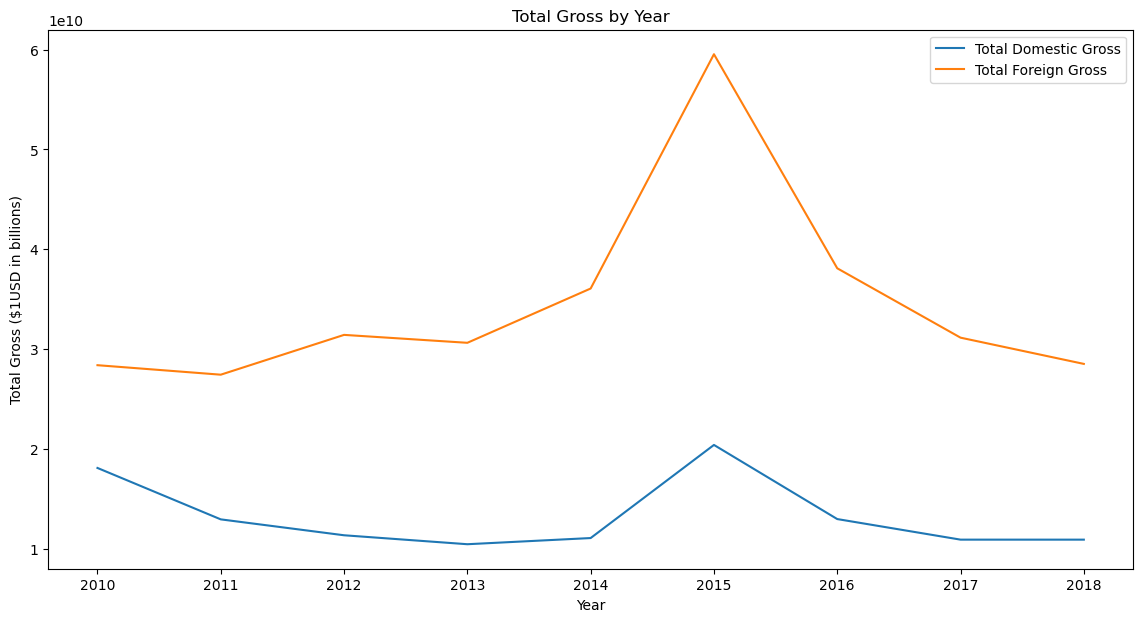

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

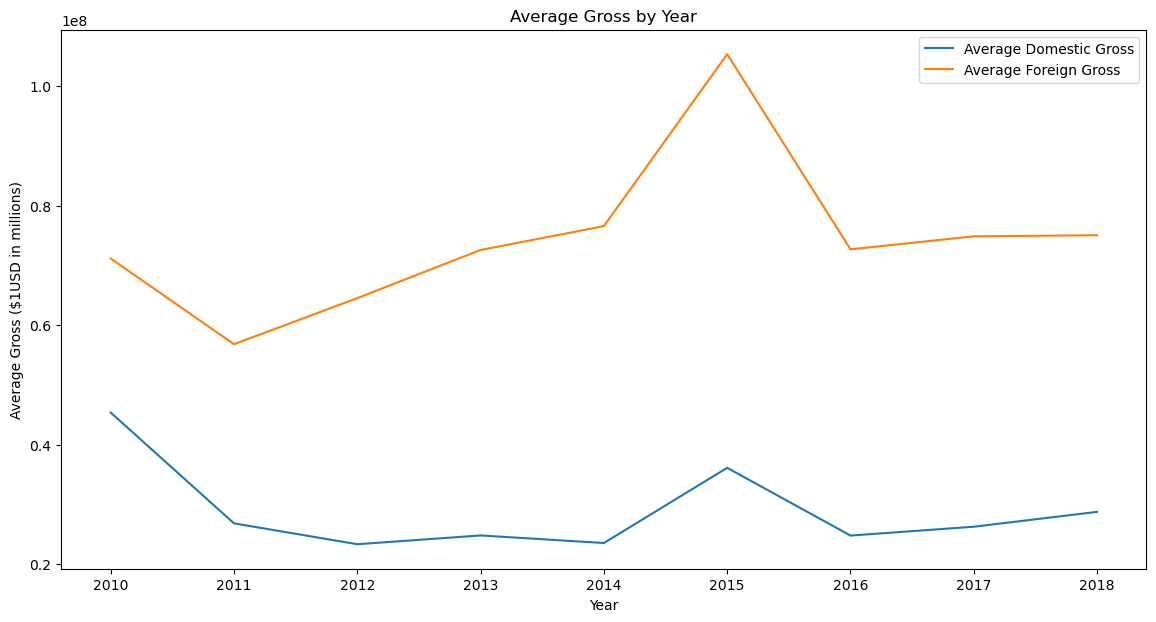

In [42]:
# Plot total and average gross by year
plt.figure(figsize=(14, 7))
sns.lineplot(data=gross_by_year, x='year', y='total_domestic_gross', label='Total Domestic Gross')
sns.lineplot(data=gross_by_year, x='year', y='total_foreign_gross', label='Total Foreign Gross')
plt.title('Total Gross by Year')
plt.xlabel('Year')
plt.ylabel('Total Gross ($1USD in billions)')
plt.legend()
plt.savefig('Total_gross_by_year')
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=gross_by_year, x='year', y='average_domestic_gross', label='Average Domestic Gross')
sns.lineplot(data=gross_by_year, x='year', y='average_foreign_gross', label='Average Foreign Gross')
plt.title('Average Gross by Year')
plt.xlabel('Year')
plt.ylabel('Average Gross ($1USD in millions)')
plt.legend()

plt.savefig('Total_avg_by_year')
plt.show()



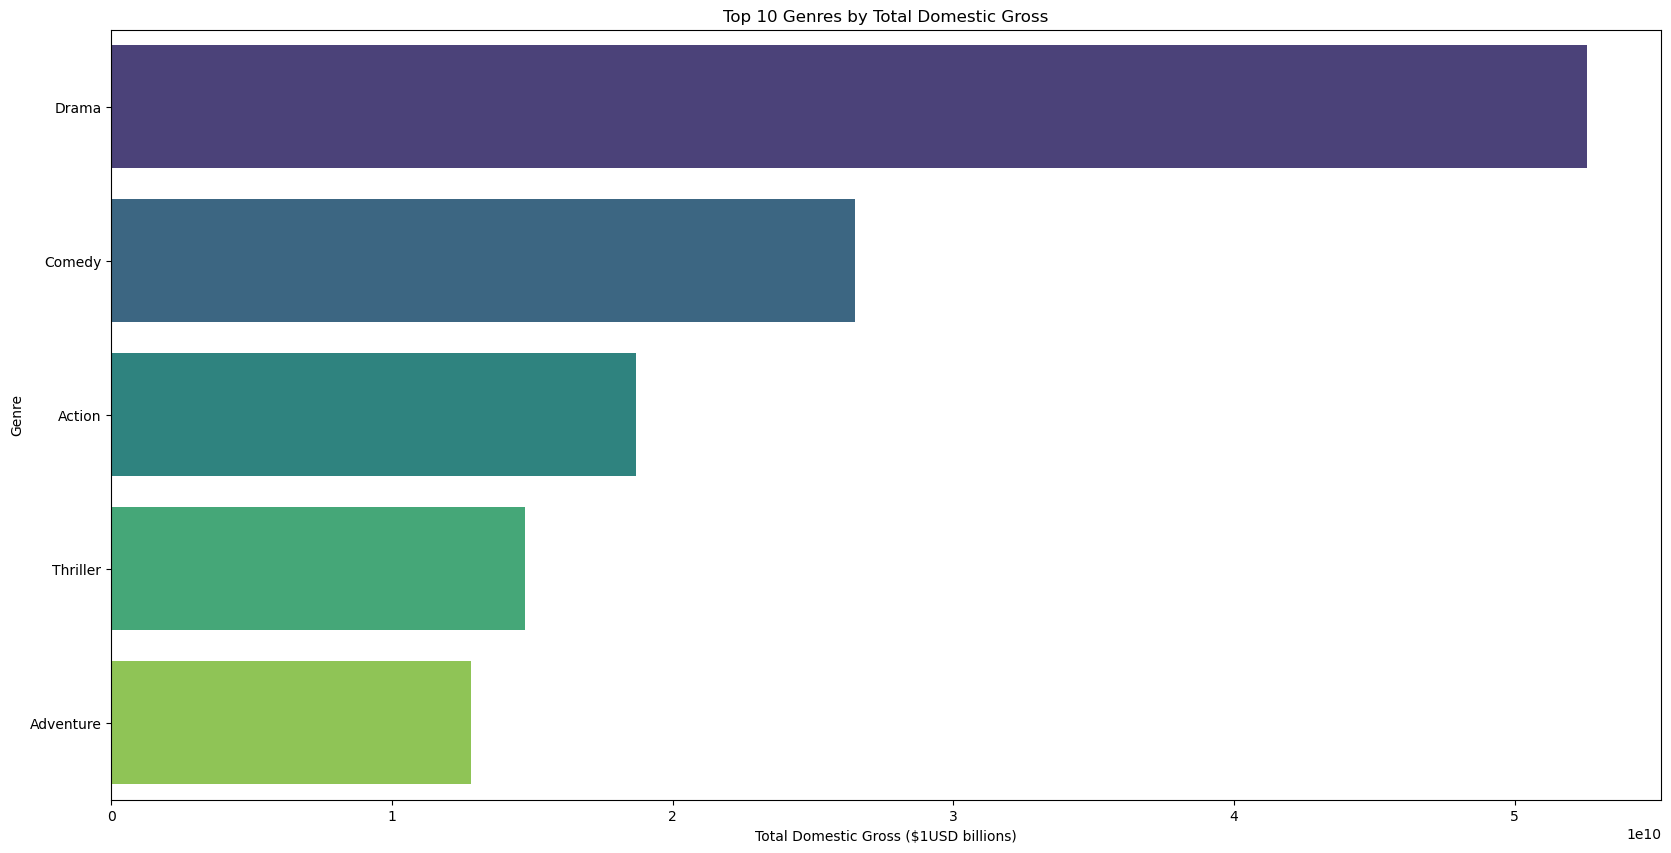

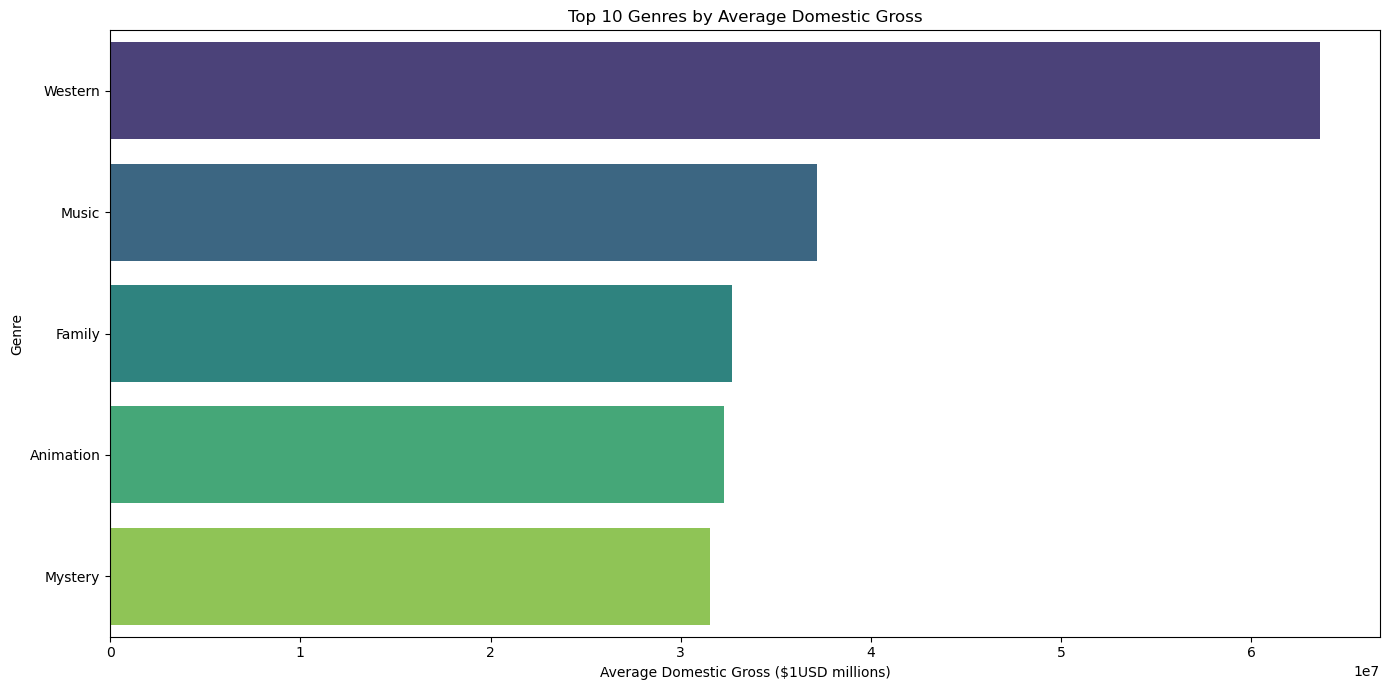

In [43]:
# Plot total and average gross by genre
plt.figure(figsize=(20, 10))
sns.barplot(data=gross_by_genre.sort_values(by='total_domestic_gross', ascending=False).head(),
            x='total_domestic_gross', y='genres', palette='viridis')
plt.title('Top 10 Genres by Total Domestic Gross')
plt.xlabel('Total Domestic Gross ($1USD billions)')
plt.ylabel('Genre')
plt.savefig('Top_10_Genres_by_domestic_gross')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(data=gross_by_genre.sort_values(by='average_domestic_gross', ascending=False).head(),
            x='average_domestic_gross', y='genres', palette='viridis')
plt.title('Top 10 Genres by Average Domestic Gross')
plt.xlabel('Average Domestic Gross ($1USD millions)')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig('Top_10_Genres_by__avg_domestic_gross')
plt.show()

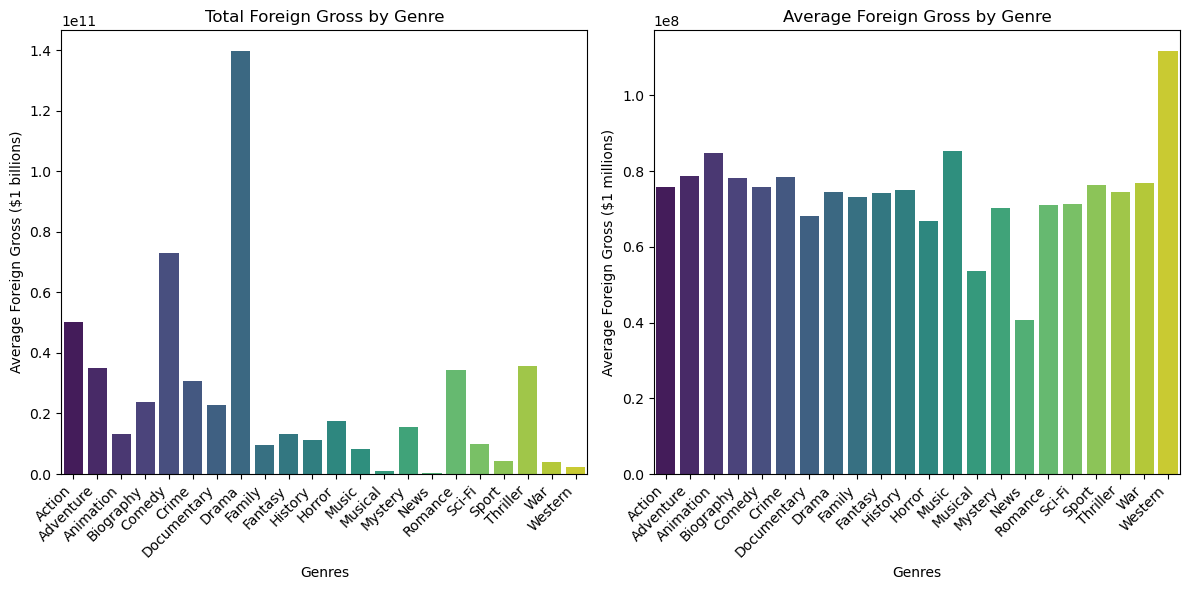

In [44]:
# Bar plot for average domestic and foreign gross by genre
plt.figure(figsize=(12, 6))

# Plot average domestic gross
plt.subplot(1, 2, 1)
sns.barplot(data=gross_by_genre, x='genres', y='total_foreign_gross', palette='viridis')
plt.title('Total Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Average Foreign Gross ($1 billions)')
plt.xticks(rotation=45, ha='right')


# Plot average foreign gross
plt.subplot(1, 2, 2)
sns.barplot(data=gross_by_genre, x='genres', y='average_foreign_gross', palette='viridis')
plt.title('Average Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Average Foreign Gross ($1 millions)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Total_foreign_and_average_gross_by_genre')
plt.show()

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


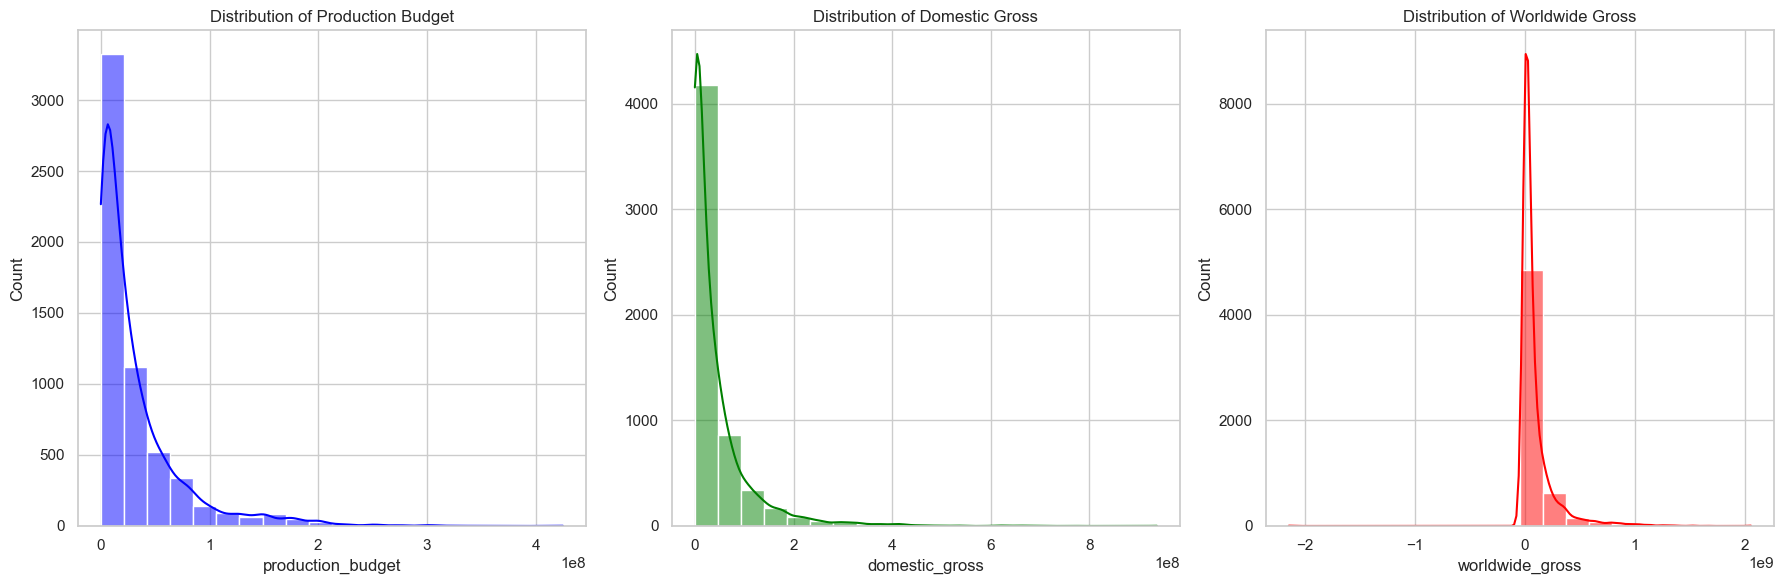

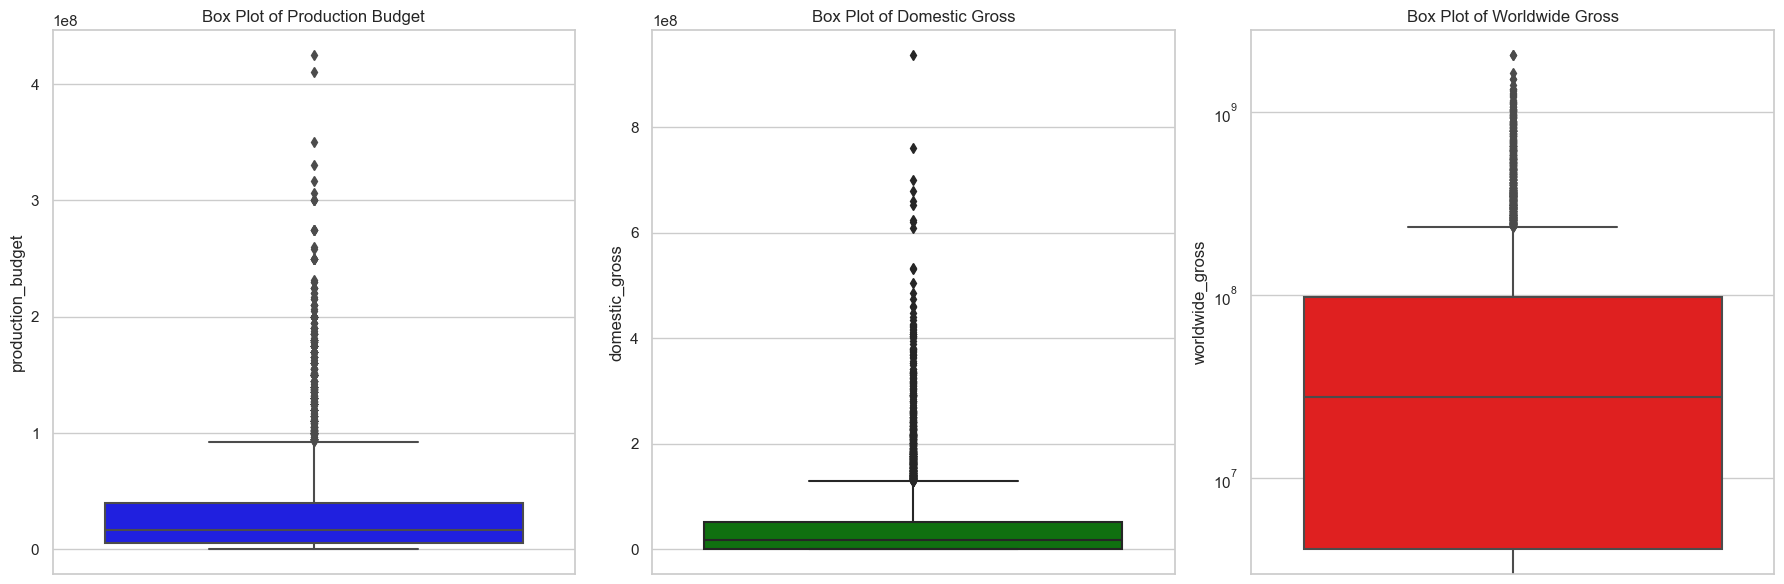

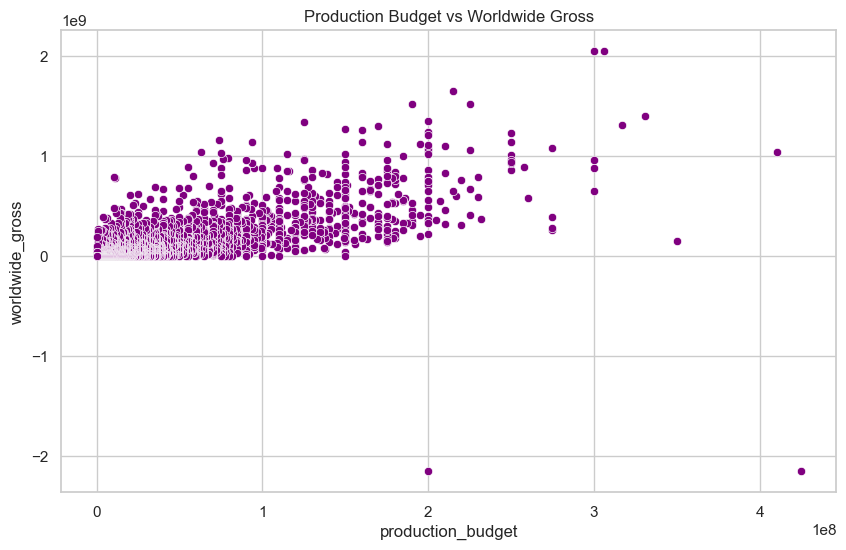

In [155]:
# plt.figure(figsize=(14,7))

# sns.barplot(data=synopsis_df.sort_values(by='director', ascending=False).head(),
#             x='production_budget', y='genres', palette='viridis')
# plt.title('Gross by Director')
# plt.xlabel('Directors')
# plt.ylabel('Gross')
# plt.tight_layout()
# plt.show()

#set style for plots
sns.set(style='whitegrid')

#Hustogram for Production Budget, Domestic Gross, and Worldwide Gross
fig, axes = plt.subplots(1,3, figsize=(18,6))

sns.histplot(synopsis_df['production_budget'], bins=20, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Production Budget')


sns.histplot(synopsis_df['domestic_gross'], bins=20, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Domestic Gross')


sns.histplot(synopsis_df['worldwide_gross'], bins=20, kde=True, ax=axes[2], color='red')
axes[2].set_title('Distribution of Worldwide Gross')

plt.tight_layout()
plt.savefig('Distributions')
plt.show()

# Box Plot for Production Budget, Domestic Gross, and Worldwide Gross
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(y=synopsis_df['production_budget'], ax=axes[0], color='blue')
axes[0].set_title('Box Plot of Production Budget')
plt.yscale('log')

sns.boxplot(y=synopsis_df['domestic_gross'], ax=axes[1], color='green')
axes[1].set_title('Box Plot of Domestic Gross')
plt.yscale('log')

sns.boxplot(y=synopsis_df['worldwide_gross'], ax=axes[2], color='red')
axes[2].set_title('Box Plot of Worldwide Gross')

plt.tight_layout()
plt.yscale('log')
plt.savefig('Boxplots')
plt.show()

# Scatter Plot for Production Budget vs Gross
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=synopsis_df['production_budget'], y=synopsis_df['worldwide_gross'], ax=ax, color='purple')
ax.set_title('Production Budget vs Worldwide Gross')
plt.savefig('Scatterplot production vs gross')
plt.show()

#### Distribution Plot: Production Budget

    Purpose: This plot displays the overall distribution of production budgets across all movies.
    
    Interpretation:
        Peak of the Distribution: Shows where most production budgets lie, whether it's in the lower, middle, or higher range.
        KDE Line (Kernel Density Estimation): The smooth curve over the histogram shows the estimated probability density function, providing a visual understanding of the budget distribution.
        Skewness: If the distribution is skewed to the right, it indicates that while most movies have relatively lower budgets, a few movies have very high budgets.

#### Box Plot: Genre vs. Domestic Gross

    Purpose: This plot shows the distribution of domestic gross revenues across different genres.
    
    Interpretation:
        Median Line: The line inside each box represents the median domestic gross for that genre.
        Interquartile Range (IQR): The box itself shows the range within which the central 50% of the data lies. The wider the box, the more varied the domestic gross within that genre.
        Whiskers and Outliers: Whiskers extend to show the range of the data, excluding outliers. Outliers are represented as individual points, showing movies that performed unusually compared to others in the same genre.

#### Scatter Plot: Production Budget vs. Worldwide Gross

    Purpose: This plot helps visualize the relationship between a movie's production budget and its worldwide gross revenue.
    
    Interpretation:
        Positive correlation: If most points trend upwards from left to right, it suggests that movies with higher production budgets tend to earn more worldwide.
        Outliers: Points that deviate significantly from the trend line (e.g., high budget with low gross or low budget with high gross) indicate movies that either overperformed or underperformed relative to their budgets.


#### Production budget by Genre

Purpose: This plot shows how production budgets vary across different movie genres.
Interpretation:

    Genre Comparison: The plot allows for a comparison of budgets across genres. For instance, genres like "Action" or "Adventure" might show higher budgets on average compared to genres like "Drama" or "Comedy."
    Logarithmic Scale: A log scale on the y-axis helps visualize data that spans multiple orders of magnitude, making it easier to compare genres with vastly different budget ranges.
    Outliers: Movies within a genre that have exceptionally high or low budgets relative to others in the same genre will appear as individual points outside the whiskers.

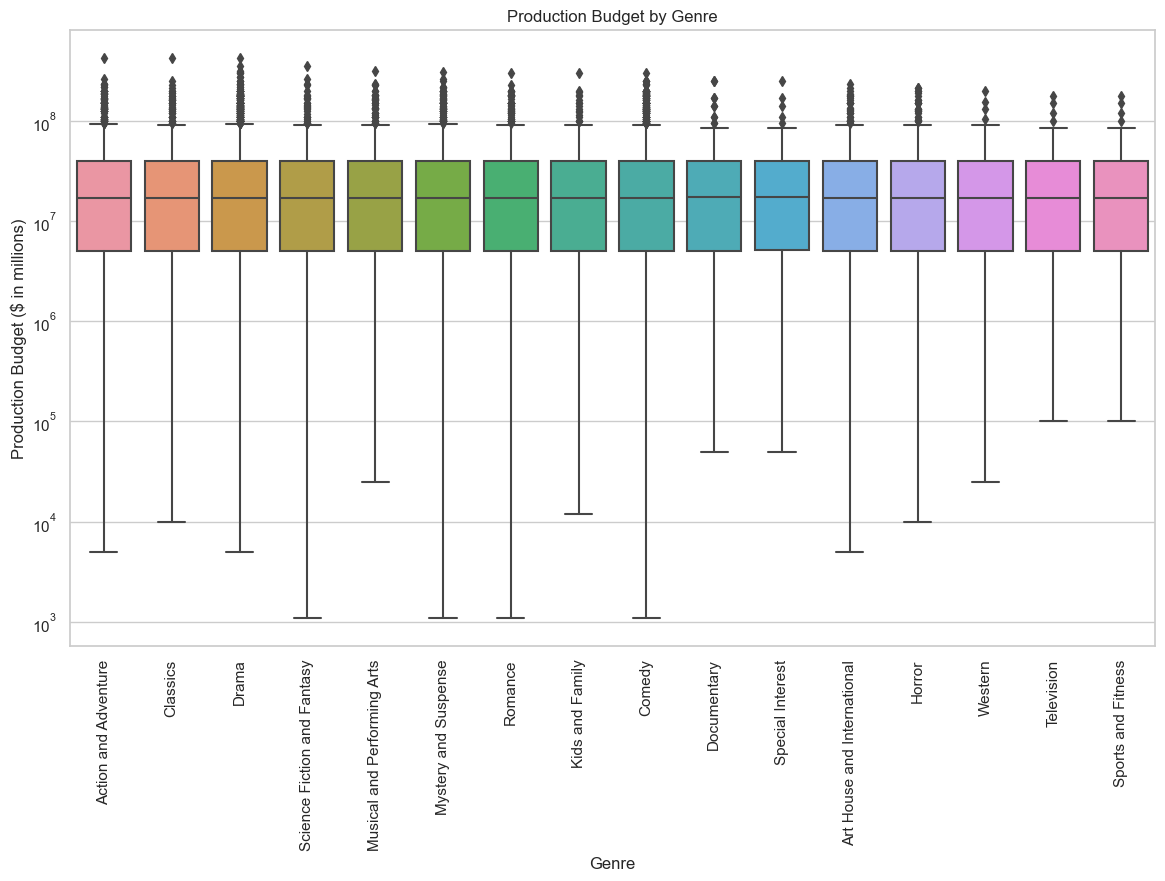

In [111]:
plt.figure(figsize=(14,8))
sns.boxplot(data=merged_genres, x='genre', y='production_budget')
plt.title('Production Budget by Genre')
plt.xlabel('Genre')
plt.ylabel('Production Budget ($ in millions)')
plt.xticks(rotation=90)
plt.yscale('log') #use log scale to handle wide rane of budgets
plt.savefig('production Budget by Genre')
plt.show()

#### Heatmap: Correlation Between Numeric Variables

This heatmap visualizes the correlation between key numerical variables such as production budget, domestic gross, and worldwide gross.
Interpretation:

    Correlation Coefficients: Values close to 1 indicate a strong positive correlation, values close to -1 indicate a strong negative correlation, and values around 0 indicate no correlation.
    Color Gradient: The heatmap uses a color gradient to represent the strength of the correlations. Darker or more intense colors indicate stronger correlations.
    Insights: For example, a strong positive correlation between production budget and worldwide gross would suggest that higher-budget movies generally earn more worldwide.

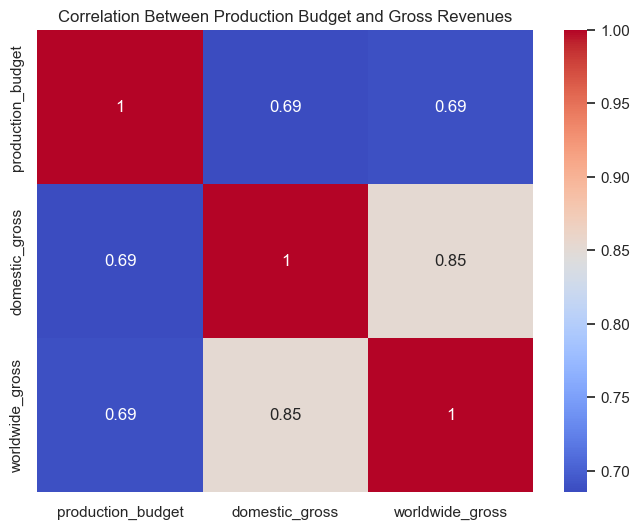

In [156]:
plt.figure(figsize=(8, 6))
sns.heatmap(synopsis_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Production Budget and Gross Revenues')
plt.savefig('Correlation between Production Budget and Gross Revenues')
plt.show()

In [51]:
# Calculate mean and confidence intervals for each genre
gross_grouped = gross_by_genre.groupby('genres').agg(
    mean_domestic_gross=('total_domestic_gross', 'mean'),
#     ci_domestic_gross=('total_domestic_gross', lambda x: 1.96 * x.std()/len(x)**0.5)
    mean_foreign_gross=('total_foreign_gross', 'mean'),
#     ci_foreign_gross=('total_foreign_gross', lambda x: 1.96 * x.std()/len(x)**0.5)
).reset_index()
gross_grouped

,genres,mean_domestic_gross,mean_foreign_gross
0,Action,1.871434e+10,5.040060e+10
1,Adventure,1.281677e+10,3.505543e+10
2,Animation,5.063948e+09,1.332415e+10
3,Biography,8.981495e+09,2.392463e+10
4,Comedy,2.650787e+10,7.320100e+10
5,Crime,1.144127e+10,3.058473e+10
6,Documentary,9.343578e+09,2.278936e+10
7,Drama,5.258798e+10,1.396726e+11
8,Family,4.220046e+09,9.442665e+09
9,Fantasy,4.615254e+09,1.312587e+10


In [52]:
save_df_to_directory(gross_grouped, './accessible_data/', 'gross_grouped.csv')

In [53]:
#merge movie_ratings_df and movies_basics_df
merged_df = pd.merge(movie_basics_df, movie_ratings_df, on='movie_id')
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5


In [54]:
save_df_to_directory(merged_df, './accessible_data/', 'movie_ratings_and_basics.csv')

In [55]:
summary_stats = merged_df.describe()
print(summary_stats)

         start_year  runtime_minutes  averagerating      numvotes
count  73856.000000     66236.000000   73856.000000  7.385600e+04
mean    2014.276132        94.654040       6.332729  3.523662e+03
std        2.614807       208.574111       1.474978  3.029402e+04
min     2010.000000         3.000000       1.000000  5.000000e+00
25%     2012.000000        81.000000       5.500000  1.400000e+01
50%     2014.000000        91.000000       6.500000  4.900000e+01
75%     2016.000000       104.000000       7.400000  2.820000e+02
max     2019.000000     51420.000000      10.000000  1.841066e+06


In [56]:
# Calculate descriptive statistics
descriptive_stats = merged_df[['averagerating', 'numvotes']].describe()
print(descriptive_stats)

       averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06


In [57]:
# Calculate measures of central tendency and measurements of dispersion
mean_rating = merged_df['averagerating'].mean()
median_rating = merged_df['averagerating'].median()
mode_rating = merged_df['averagerating'].mode()[0]

std_dev_rating = merged_df['averagerating'].std()
variance_rating = merged_df['averagerating'].var()

mean_votes = merged_df['numvotes'].mean()
median_votes = merged_df['numvotes'].median()
mode_votes = merged_df['numvotes'].mode()[0]

std_dev_votes =merged_df['numvotes'].std()
variance_votes = merged_df['numvotes'].var()

print(f"Mean Rating: {mean_rating}")
print(f"Median Rating: {median_rating}")
print(f"Mode Rating: {mode_rating}")
print(f"Standard Deviation of Ratings: {std_dev_rating}")
print(f"Variance of Ratings: {variance_rating}")

print(f"Mean Votes: {mean_votes}")
print(f"Median Votes: {median_votes}")
print(f"Mode Votes: {mode_votes}")
print(f"Standard Deviation of Votes: {std_dev_votes}")
print(f"Variance of Votes: {variance_votes}")

Mean Rating: 6.332728552859619
Median Rating: 6.5
Mode Rating: 7.0
Standard Deviation of Ratings: 1.4749783548957582
Variance of Ratings: 2.1755611474109973
Mean Votes: 3523.6621669194105
Median Votes: 49.0
Mode Votes: 6
Standard Deviation of Votes: 30294.022971103946
Variance of Votes: 917727827.7737737


In [58]:
# Split the genres column
merged_df.loc[merged_df.index, 'genres'] = merged_df['genres'].str.split(',')

# Explode the genres column
exploded_df = merged_df.explode('genres')
exploded_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action,7.0,77
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime,7.0,77
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Drama,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Biography,7.2,43
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Drama,7.2,43
...,...,...,...,...,...,...,...,...
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,Drama,8.7,136
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,Family,8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5


In [59]:
# Convert columns to appropriate data types
exploded_df['average_rating'] = exploded_df['averagerating'].astype(float)
exploded_df['num_votes'] = exploded_df['numvotes'].astype(int)
exploded_df['runtime_minutes'] = exploded_df['runtime_minutes'].astype(float)
exploded_df['start_year'] = exploded_df['start_year'].astype(int)


In [60]:
# Reset the index to avoid issues with duplicate labels
exploded_df.reset_index(drop=True, inplace=True)

# Remove outliers from 'average_rating' and 'num_votes' using Z-score
exploded_df['zscore_rating'] = zscore(exploded_df['average_rating'])
exploded_df['zscore_votes'] = zscore(exploded_df['num_votes'])

# Filter out the outliers
df_cleaned = exploded_df[(exploded_df['zscore_rating'].abs() <= 3) & (exploded_df['zscore_votes'].abs() <= 3)]

# Drop the Z-score columns as they are no longer needed
df_cleaned.drop(columns=['zscore_rating', 'zscore_votes'], inplace=True)


C:\Users\omend\AppData\Local\Temp\ipykernel_35008\3486954560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=['zscore_rating', 'zscore_votes'], inplace=True)


In [61]:
save_df_to_directory(exploded_df, './accessible_data/', 'exploded_df.csv')

In [62]:
save_df_to_directory(df_cleaned, './accessible_data/', 'df_cleaned.csv')

In [63]:
# Display the first few rows of the cleaned DataFrame
df_cleaned.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,average_rating,num_votes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action,7.0,77,7.0,77
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime,7.0,77,7.0,77
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,Drama,7.0,77,7.0,77
3,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Biography,7.2,43,7.2,43
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Drama,7.2,43,7.2,43


In [64]:
# Descriptive Analysis
# Summary statistics
descriptive_stats = df_cleaned.describe()
print(descriptive_stats)

          start_year  runtime_minutes  averagerating       numvotes  \
count  127169.000000    116915.000000  127169.000000  127169.000000   
mean     2014.225472        94.797383       6.322133    2099.382176   
std         2.579389       157.768025       1.421154    9615.463999   
min      2010.000000         3.000000       2.000000       5.000000   
25%      2012.000000        82.000000       5.400000      16.000000   
50%      2014.000000        91.000000       6.400000      62.000000   
75%      2016.000000       104.000000       7.300000     392.000000   
max      2019.000000     51420.000000      10.000000  119149.000000   

       average_rating      num_votes  
count   127169.000000  127169.000000  
mean         6.322133    2099.382176  
std          1.421154    9615.463999  
min          2.000000       5.000000  
25%          5.400000      16.000000  
50%          6.400000      62.000000  
75%          7.300000     392.000000  
max         10.000000  119149.000000  


In [65]:
# Group by genres and calculate mean ratings and votes
genre_stats = df_cleaned.groupby('genres').agg({'average_rating': 'mean', 'num_votes': 'mean'}).sort_values(by='average_rating', ascending=False)
genre_stats.head(10)

,average_rating,num_votes
genres,,
Short,8.800000,8.000000
Documentary,7.342013,261.511539
Game-Show,7.300000,1734.500000
News,7.271330,212.986183
Biography,7.165922,2342.303296
Music,7.116513,1491.909744
History,7.050321,1375.040300
Sport,6.972455,1735.073567
War,6.617696,1958.442993


In [66]:
save_df_to_directory(genre_stats, './accessible_data/', 'Genre_stats.csv')

### Inferential Analysis

In [67]:

# Perform a t-test to compare sample mean to population mean
overall_mean_rating = df_cleaned['average_rating'].mean()
t_stat_ratings, p_value_ratings = ttest_1samp(df_cleaned['average_rating'], overall_mean_rating)

print(f"T-Statistic for Ratings: {t_stat_ratings}")
print(f"P-Value for Ratings: {p_value_ratings}")

overall_mean_votes = df_cleaned['num_votes'].mean()
t_stat_votes, p_value_votes = ttest_1samp(df_cleaned['num_votes'], overall_mean_votes)

print(f"T-Statistic for Votes: {t_stat_votes}")
print(f"P-Value for Votes: {p_value_votes}")

T-Statistic for Ratings: 0.0
P-Value for Ratings: 1.0
T-Statistic for Votes: 0.0
P-Value for Votes: 1.0


### Visualizations

#### Distribution of average ratings

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


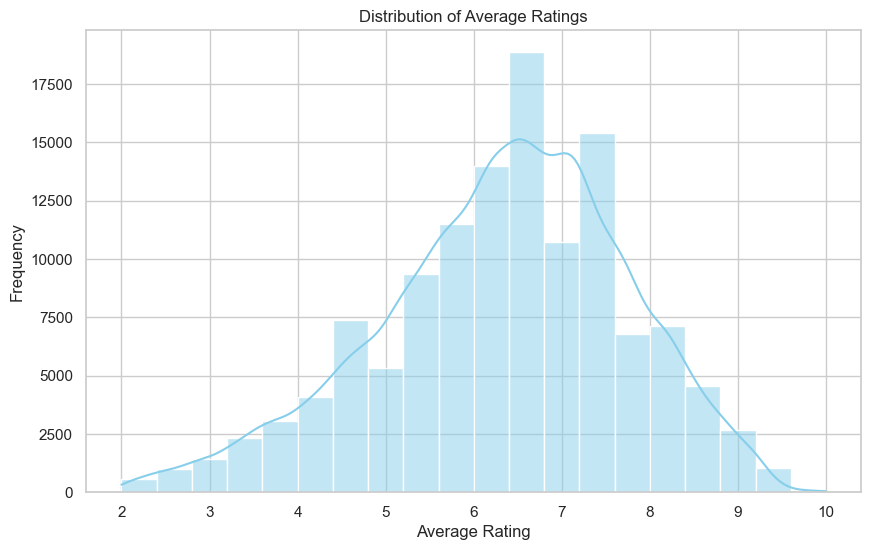

In [68]:

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['average_rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.savefig('Distribution_of_Avg_Ratings')
plt.show()

#### Distribution of number of votes

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


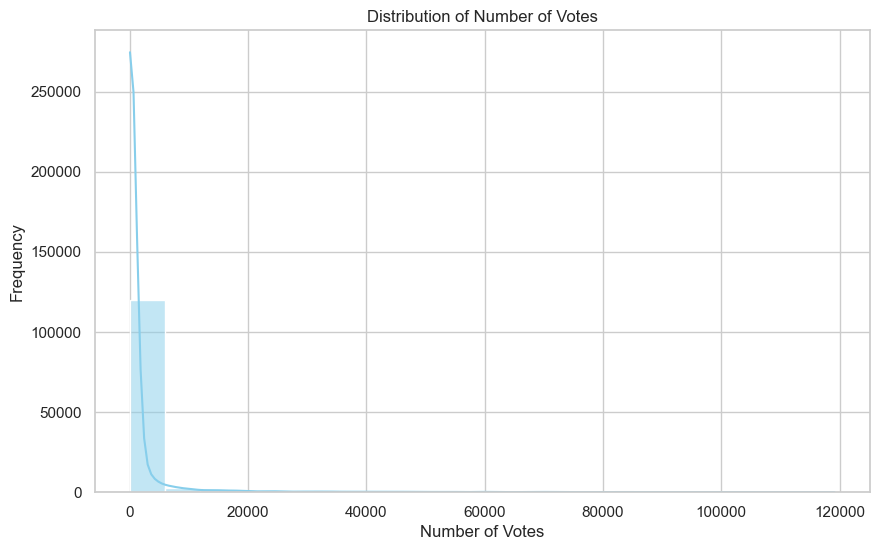

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['num_votes'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.savefig('Distribution_of_num_of_votes')
plt.show()

#### Number of votes by genre

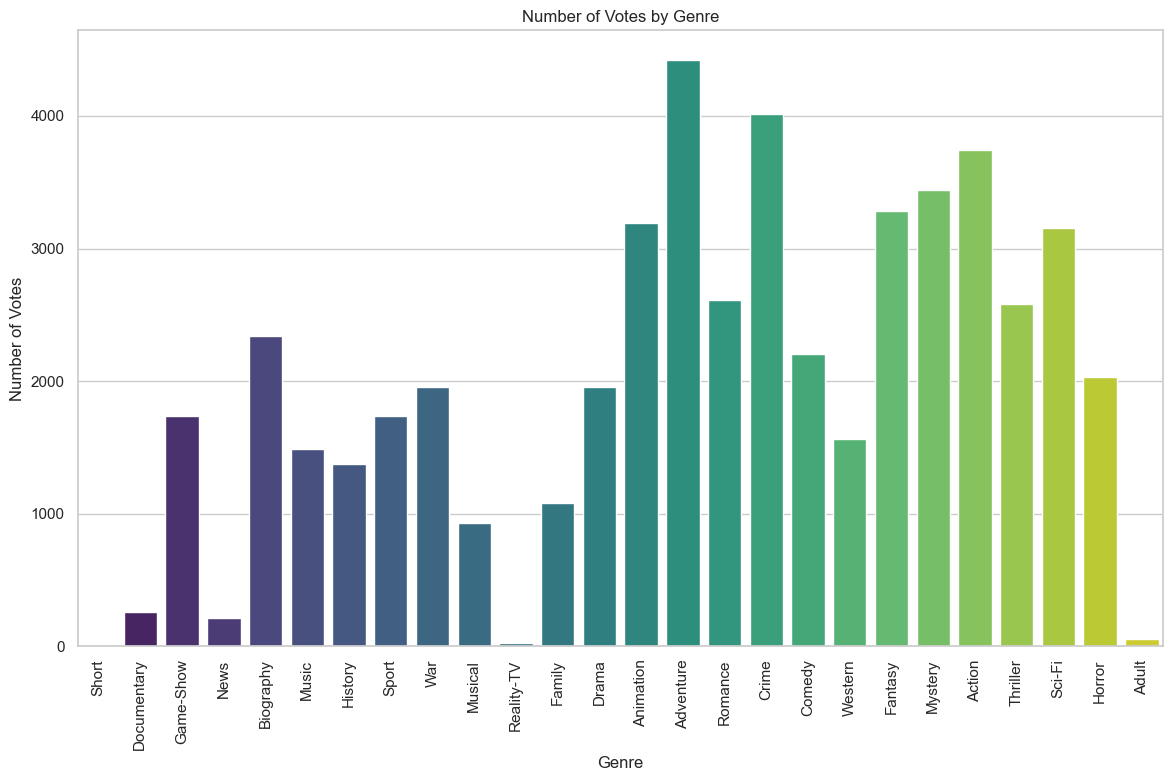

In [70]:
plt.figure(figsize=(14, 8))
sns.barplot(x=genre_stats.index, y=genre_stats['num_votes'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Number of Votes by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Votes')
plt.savefig('Number_of_Votes_by_genre')
plt.show()

#### Average rating by genre

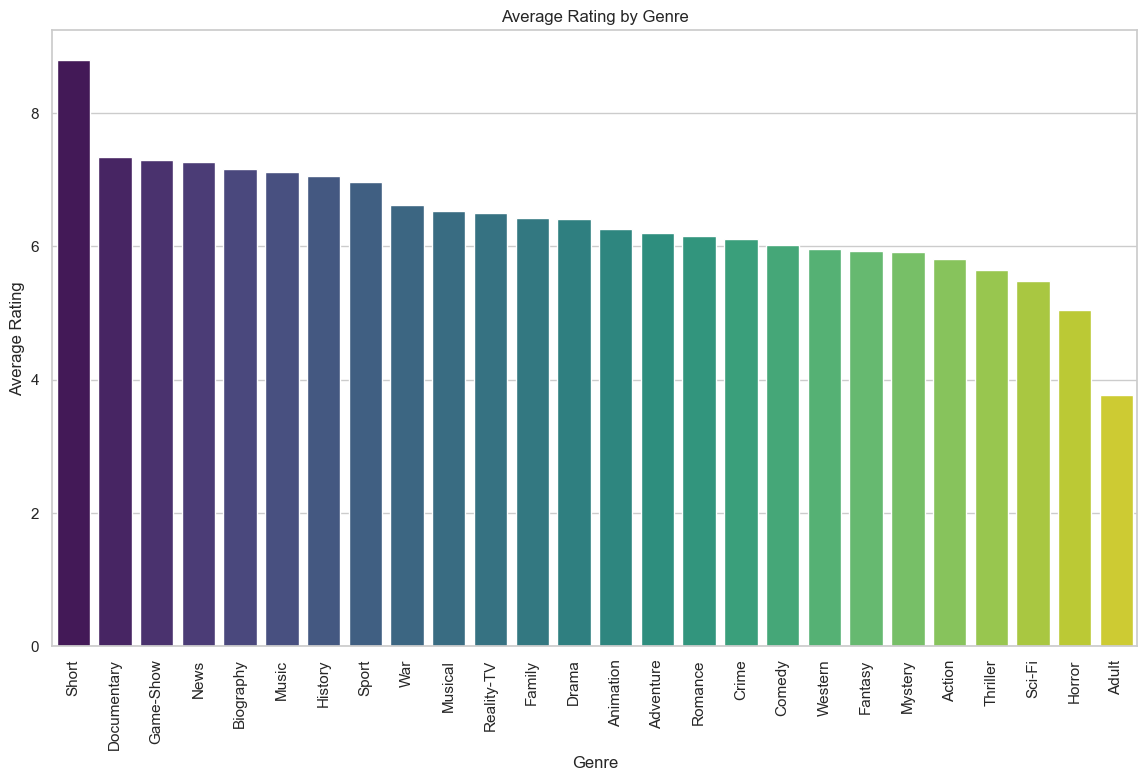

In [71]:
plt.figure(figsize=(14, 8))
sns.barplot(x=genre_stats.index, y=genre_stats['average_rating'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.savefig('Average_rating_by_genre')
plt.show()

### Calculating descriptive statistics for each genre

In [72]:
genre_stats = exploded_df.groupby('genres').agg(
    count=pd.NamedAgg(column='averagerating', aggfunc='count'),
    mean_rating=pd.NamedAgg(column='averagerating', aggfunc='mean'),
    median_rating=pd.NamedAgg(column='averagerating', aggfunc='median'),
    mode_rating=pd.NamedAgg(column='averagerating', aggfunc=lambda x: x.mode()[0]),
    std_dev_rating=pd.NamedAgg(column='averagerating', aggfunc='std'),
    variance_rating=pd.NamedAgg(column='averagerating', aggfunc='var'),
    mean_votes=pd.NamedAgg(column='numvotes', aggfunc='mean'),
    median_votes=pd.NamedAgg(column='numvotes', aggfunc='median'),
    mode_votes=pd.NamedAgg(column='numvotes', aggfunc=lambda x: x.mode()[0]),
    std_dev_votes=pd.NamedAgg(column='numvotes', aggfunc='std'),
    variance_votes=pd.NamedAgg(column='numvotes', aggfunc='var')
).reset_index()
genre_stats

,genres,count,mean_rating,median_rating,mode_rating,std_dev_rating,variance_rating,mean_votes,median_votes,mode_votes,std_dev_votes,variance_votes
0,Action,6988,5.810361,6.00,6.5,1.513833,2.291692,14476.485690,170.0,5,70102.991766,4.914429e+09
1,Adult,3,3.766667,3.40,2.0,1.975686,3.903333,54.666667,28.0,8,64.291005,4.133333e+03
2,Adventure,3817,6.196201,6.40,6.6,1.514963,2.295114,22067.746660,111.0,6,93018.384213,8.652420e+09
3,Animation,1743,6.248308,6.50,6.8,1.353982,1.833268,8808.549627,97.0,10,45339.233918,2.055646e+09
4,Biography,3809,7.162274,7.20,7.0,1.072788,1.150874,5673.259648,40.0,6,39346.364036,1.548136e+09
5,Comedy,17290,6.002689,6.10,6.2,1.404156,1.971653,4297.617409,95.0,6,28443.308108,8.090218e+08
6,Crime,4611,6.115441,6.20,6.5,1.340714,1.797514,8594.959011,169.0,6,41371.228672,1.711579e+09
7,Documentary,17753,7.332090,7.40,7.2,1.086263,1.179967,266.960232,19.0,5,1871.784743,3.503578e+06
8,Drama,30788,6.401559,6.50,6.2,1.277601,1.632264,3883.574769,71.0,6,28632.222464,8.198042e+08
9,Family,3412,6.394725,6.50,6.5,1.384528,1.916917,2531.274912,52.0,6,22860.575825,5.226059e+08


In [73]:
save_df_to_directory(genre_stats ,'./accessible_data/','genre_stats.csv')

In [74]:
threshold = 500
filtered_df = merged_df[merged_df['runtime_minutes'] <= threshold]

In [75]:
filtered_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama],6.9,4517
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]",6.5,119
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"[Adventure, Animation, Comedy]",8.1,263
...,...,...,...,...,...,...,...,...
73849,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,[Drama],8.4,365
73850,tt9913056,Swarm Season,Swarm Season,2019,86.0,[Documentary],6.2,5
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,[Documentary],6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"[Drama, Family]",8.7,136


In [76]:
#descriptive statistics
avg_rating = np.mean(filtered_df['averagerating'])
median_runtime = np.median(filtered_df['runtime_minutes'])

In [77]:
avg_rating

6.321677286866186

In [78]:
median_runtime

91.0

In [79]:
save_df_to_directory(filtered_df, './accessible_data/', 'filtered_df.csv')

### Distribution Plot of genre

In [80]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df.groupby('genres')[column].transform(lambda x: x.quantile(0.25))
    Q3 = df.groupby('genres')[column].transform(lambda x: x.quantile(0.75))
    IQR = Q3 - Q1
    return df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]


In [81]:
df_no_outliers = remove_outliers_iqr(exploded_df, 'average_rating')
df_no_outliers = remove_outliers_iqr(df_no_outliers, 'num_votes')

In [82]:
# Add inferential statistics: confidence intervals and t-tests
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(n)
    margin_of_error = std_err * norm.ppf((1 + confidence) / 2)
    return mean - margin_of_error, mean + margin_of_error

In [83]:
def add_inferential_stats(df):
    conf_intervals_rating = []
    conf_intervals_votes = []
    t_stats_rating = []
    p_values_rating = []
    t_stats_votes = []
    p_values_votes = []

    for genre in df['genres']:
        data = df_no_outliers[df_no_outliers['genres'] == genre]
        ratings = data['average_rating']
        votes = data['num_votes']

        # Confidence intervals
        conf_intervals_rating.append(confidence_interval(ratings))
        conf_intervals_votes.append(confidence_interval(votes))

        # T-tests (compare sample mean to overall mean)
        overall_mean_rating = df_no_outliers['average_rating'].mean()
        t_stat_rating, p_value_rating = ttest_1samp(ratings, overall_mean_rating)
        t_stats_rating.append(t_stat_rating)
        p_values_rating.append(p_value_rating)

        overall_mean_votes = df_no_outliers['num_votes'].mean()
        t_stat_votes, p_value_votes = ttest_1samp(votes, overall_mean_votes)
        t_stats_votes.append(t_stat_votes)
        p_values_votes.append(p_value_votes)

    df['conf_interval_rating'] = conf_intervals_rating
    df['conf_interval_votes'] = conf_intervals_votes
    df['t_stat_rating'] = t_stats_rating
    df['p_value_rating'] = p_values_rating
    df['t_stat_votes'] = t_stats_votes
    df['p_value_votes'] = p_values_votes

add_inferential_stats(genre_stats)


C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [84]:
# Remove outliers for 'average_rating'
df_no_outliers_ratings = remove_outliers_iqr(exploded_df, 'average_rating')

# Remove outliers for 'num_votes'
df_no_outliers_votes = remove_outliers_iqr(exploded_df, 'num_votes')

In [85]:
add_inferential_stats(genre_stats)
# Display the updated genre_stats DataFrame
print(genre_stats)

         genres  count  mean_rating  median_rating  mode_rating  \
0        Action   6988     5.810361           6.00          6.5   
1         Adult      3     3.766667           3.40          2.0   
2     Adventure   3817     6.196201           6.40          6.6   
3     Animation   1743     6.248308           6.50          6.8   
4     Biography   3809     7.162274           7.20          7.0   
5        Comedy  17290     6.002689           6.10          6.2   
6         Crime   4611     6.115441           6.20          6.5   
7   Documentary  17753     7.332090           7.40          7.2   
8         Drama  30788     6.401559           6.50          6.2   
9        Family   3412     6.394725           6.50          6.5   
10      Fantasy   2126     5.919473           6.00          6.2   
11    Game-Show      2     7.300000           7.30          5.6   
12      History   2825     7.040956           7.20          7.6   
13       Horror   7674     5.003440           5.00          5.

C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [86]:
save_df_to_directory(genre_stats,'./accessible_data/','infrential_genre_stats.csv')

In [87]:
save_df_to_directory(df_no_outliers_votes, './accessible_data/', 'df_no_outlier_votes.csv')

In [88]:
save_df_to_directory(df_no_outliers_ratings, './accessible_data/', 'df_no_outlier_ratings.csv')

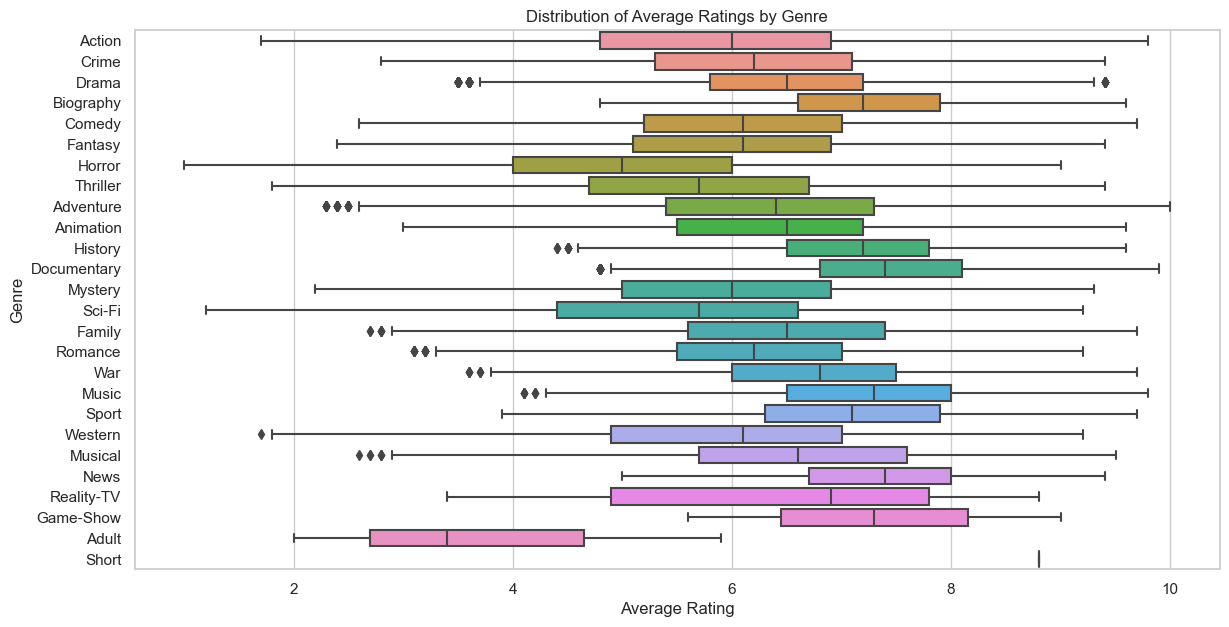

In [89]:
# Distribution of average ratings by genre
plt.figure(figsize=(14, 7))
sns.boxplot(x='average_rating', y='genres', data=df_no_outliers_ratings)
plt.title('Distribution of Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.savefig('Distribution_of_Avg_Ratings_by_Genre')
plt.show()

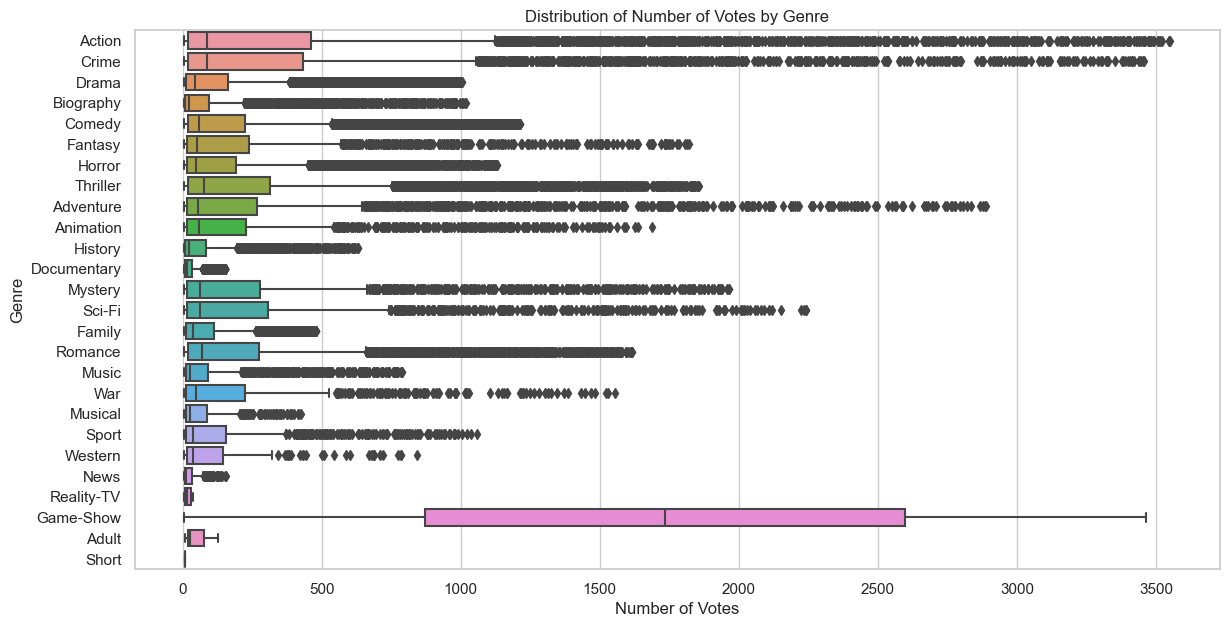

In [90]:
# Distribution of number of votes by genre
plt.figure(figsize=(14, 7))
sns.boxplot(x='num_votes', y='genres', data=df_no_outliers_votes)
plt.title('Distribution of Number of Votes by Genre')
plt.xlabel('Number of Votes')
plt.ylabel('Genre')
plt.savefig('Distribution_of_number_of_votes_by_Genre')
plt.show()

### Barplot for top genre

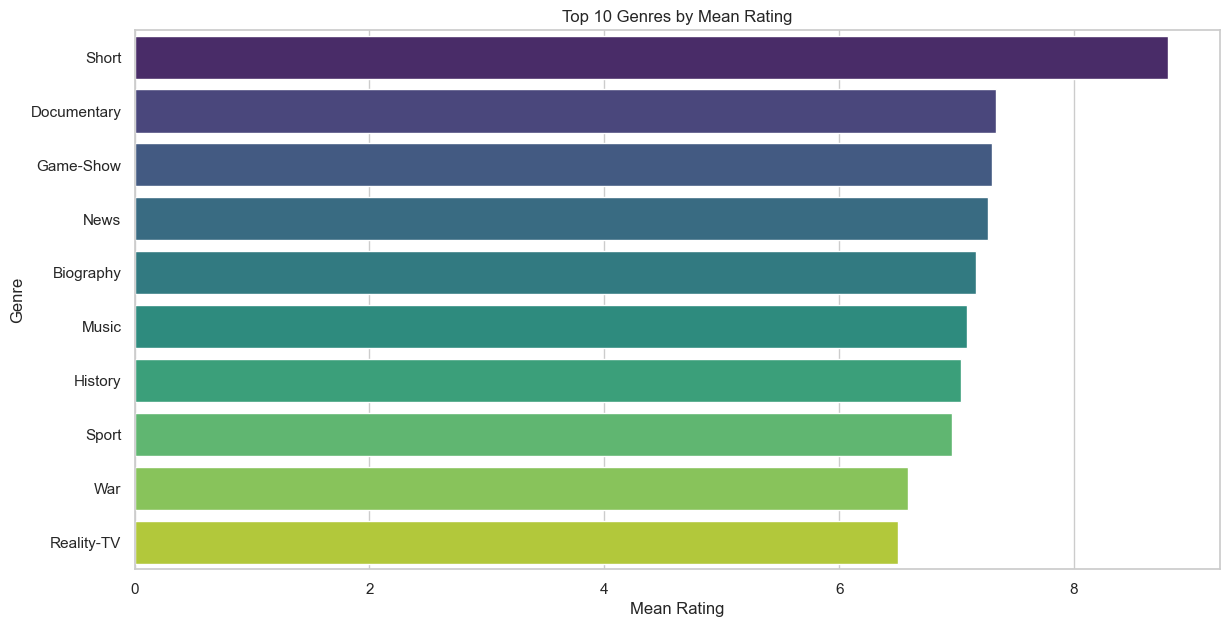

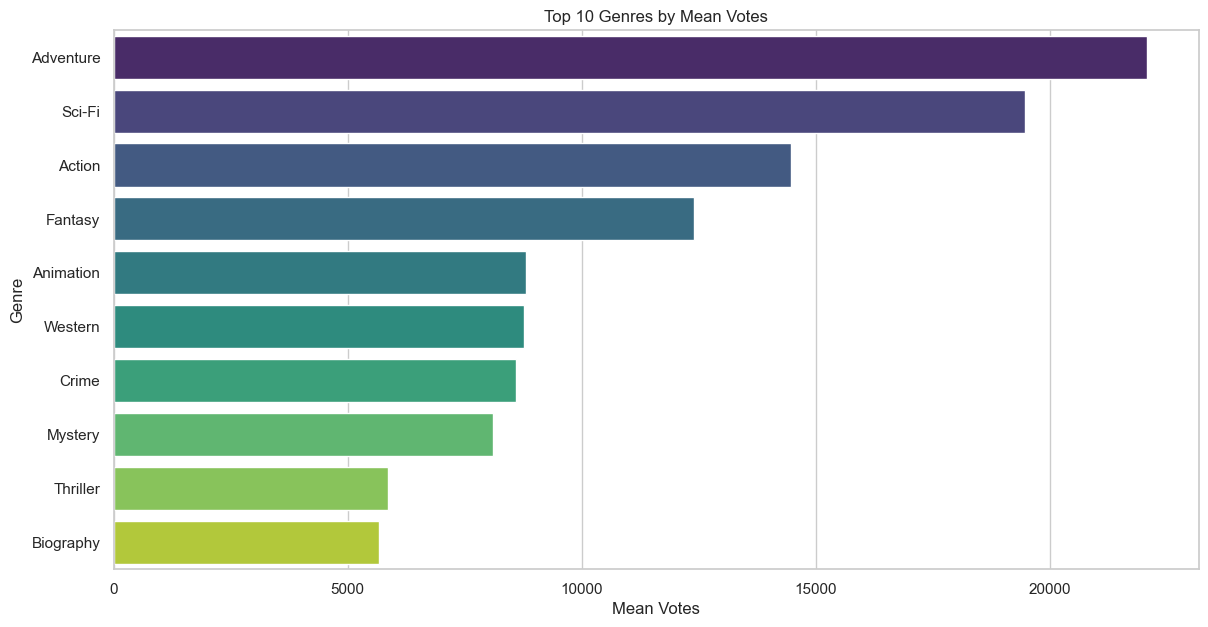

In [91]:
# Bar plot for mean ratings by genre
plt.figure(figsize=(14, 7))
top_genres_by_mean_rating = genre_stats.sort_values(by='mean_rating', ascending=False).head(10)
sns.barplot(x='mean_rating', y='genres', data=top_genres_by_mean_rating, palette='viridis')
plt.title('Top 10 Genres by Mean Rating')
plt.xlabel('Mean Rating')
plt.ylabel('Genre')
plt.savefig('Top_10_Genres_by_mean_rating')
plt.show()

# Bar plot for mean votes by genre
plt.figure(figsize=(14, 7))
top_genres_by_mean_votes = genre_stats.sort_values(by='mean_votes', ascending=False).head(10)
sns.barplot(x='mean_votes', y='genres', data=top_genres_by_mean_votes, palette='viridis')
plt.title('Top 10 Genres by Mean Votes')
plt.xlabel('Mean Votes')
plt.ylabel('Genre')
plt.savefig('Top_10_Genres_by_mean_votes')
plt.show()

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


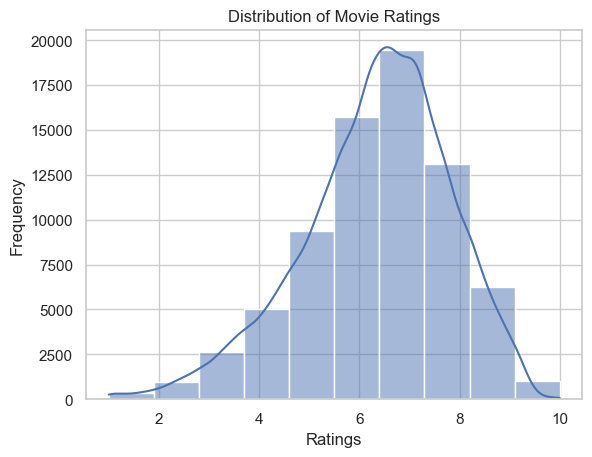

In [92]:
#Distribution of movie ratings
sns.histplot(merged_df['averagerating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.savefig('Distribution_of_movie_ratings')
plt.show()

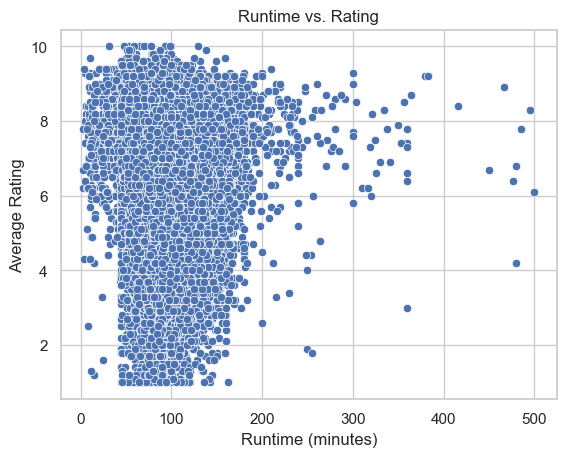

In [93]:
#Relationship between runtime and rating
sns.scatterplot(x='runtime_minutes', y='averagerating', data=filtered_df)
plt.title('Runtime vs. Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.savefig('Runtime_vs_Ratings')
plt.show()

### Hypothesis testing for genre

In [94]:
# Mean rating for all movies
overall_mean_rating = exploded_df['averagerating'].mean()

# T-test for the genre "Drama"
drama_ratings = exploded_df[exploded_df['genres'] == 'Drama']['averagerating']
t_stat_drama, p_value_drama = stats.ttest_1samp(drama_ratings, overall_mean_rating)
print(f"T-Statistic for Drama: {t_stat_drama}")
print(f"P-Value for Drama: {p_value_drama}")

# T-test for the genre "Comedy"
comedy_ratings = exploded_df[exploded_df['genres'] == 'Comedy']['averagerating']
t_stat_comedy, p_value_comedy = stats.ttest_1samp(comedy_ratings, overall_mean_rating)
print(f"T-Statistic for Comedy: {t_stat_comedy}")
print(f"P-Value for Comedy: {p_value_comedy}")


T-Statistic for Drama: 13.487700643974584
P-Value for Drama: 2.4219683961342674e-41
T-Statistic for Comedy: -28.155402310438262
P-Value for Comedy: 1.422072989103994e-170


C:\Users\omend\AppData\Local\Temp\ipykernel_35008\3060826122.py:6: DeprecationWarning: Please use `ttest_1samp` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat_drama, p_value_drama = stats.ttest_1samp(drama_ratings, overall_mean_rating)
C:\Users\omend\AppData\Local\Temp\ipykernel_35008\3060826122.py:12: DeprecationWarning: Please use `ttest_1samp` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat_comedy, p_value_comedy = stats.ttest_1samp(comedy_ratings, overall_mean_rating)


#### Correlation Analysis by Genre

Examine the relationship between average rating and number of votes for each genre.

In [95]:
# Filter genres with at least two movies for correlation calculation
valid_genres = exploded_df['genres'].value_counts()[exploded_df['genres'].value_counts() > 1].index
df_valid_genres = exploded_df[exploded_df['genres'].isin(valid_genres)]


In [96]:
valid_genres

Index(['Drama', 'Documentary', 'Comedy', 'Thriller', 'Horror', 'Action',
       'Romance', 'Crime', 'Adventure', 'Biography', 'Family', 'Mystery',
       'History', 'Sci-Fi', 'Fantasy', 'Music', 'Animation', 'Sport', 'War',
       'Musical', 'News', 'Western', 'Reality-TV', 'Adult', 'Game-Show'],
      dtype='object', name='genres')

In [97]:
df_valid_genres

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,average_rating,num_votes,zscore_rating,zscore_votes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action,7.0,77,7.0,77,0.477801,-0.137670
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime,7.0,77,7.0,77,0.477801,-0.137670
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,Drama,7.0,77,7.0,77,0.477801,-0.137670
3,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Biography,7.2,43,7.2,43,0.614973,-0.138565
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Drama,7.2,43,7.2,43,0.614973,-0.138565
...,...,...,...,...,...,...,...,...,...,...,...,...
129288,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6,6.2,6,-0.070885,-0.139540
129289,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,Drama,8.7,136,8.7,136,1.643760,-0.136116
129290,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,Family,8.7,136,8.7,136,1.643760,-0.136116
129291,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8,8.5,8,1.506588,-0.139487


In [98]:
save_df_to_directory(df_valid_genres,'./accessible_data/', 'valid_genres.csv')

C:\Users\omend\AppData\Local\Temp\ipykernel_35008\1339320202.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  lambda x: stats.pearsonr(x['averagerating'], x['numvotes'])[0]


         genres  correlation
0        Action     0.146936
1         Adult    -0.863389
2     Adventure     0.134509
3     Animation     0.145932
4     Biography     0.042011
5        Comedy     0.077531
6         Crime     0.117262
7   Documentary    -0.004429
8         Drama     0.070571
9        Family     0.027621
10      Fantasy     0.110488
11    Game-Show    -1.000000
12      History     0.031603
13       Horror     0.128537
14        Music     0.003716
15      Musical     0.043450
16      Mystery     0.123256
17         News     0.067643
18   Reality-TV    -0.313450
19      Romance     0.075883
20       Sci-Fi     0.212596
21        Sport     0.037138
22     Thriller     0.121713
23          War     0.057012
24      Western     0.116525


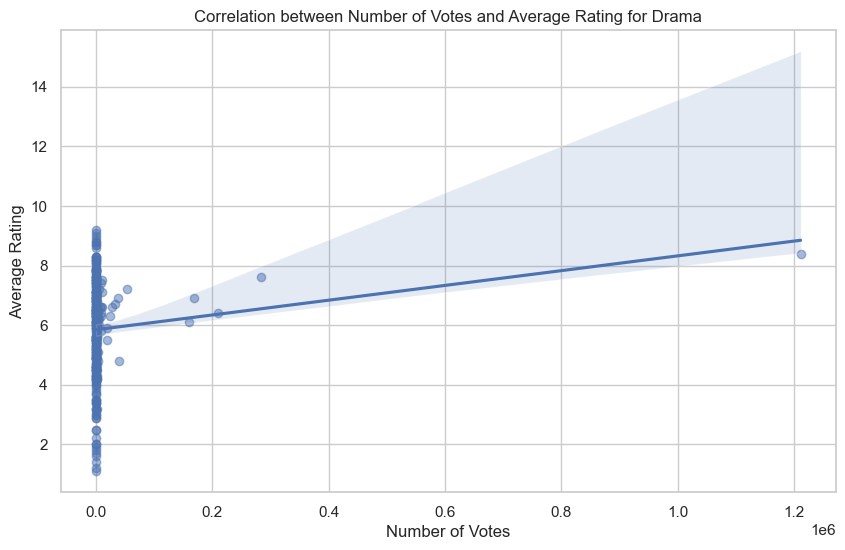

In [99]:
# Correlation between average rating and number of votes by genre
correlation_by_genre = df_valid_genres.groupby('genres').apply(
    lambda x: stats.pearsonr(x['averagerating'], x['numvotes'])[0]
).reset_index(name='correlation')

print(correlation_by_genre)

# Scatter plot with regression line for a specific genre (e.g., "Drama")
plt.figure(figsize=(10, 6))
sns.regplot(x='numvotes', y='averagerating', data=exploded_df[exploded_df['genres'] == 'Western'], scatter_kws={'alpha':0.5})
plt.title('Correlation between Number of Votes and Average Rating for Drama')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.show()


Let's perform the following analyses on the dataset:

    1. Sample Analysis
    2. Variance
    3. Expected Value (Mean)
    4. Normal Distribution Fit
    5. Z-Score Calculation
    6. Significance Testing (Hypothesis Testing)

##### We'll use the average_rating and num_votes columns from the dataset for these analyses.

In [100]:
# Select relevant columns
ratings_votes = exploded_df[['genres','averagerating', 'numvotes']].dropna()

# Display the first few rows of the dataframe
ratings_votes.head(10)

,genres,averagerating,numvotes
0,Action,7.0,77
1,Crime,7.0,77
2,Drama,7.0,77
3,Biography,7.2,43
4,Drama,7.2,43
5,Drama,6.9,4517
6,Comedy,6.1,13
7,Drama,6.1,13
8,Comedy,6.5,119
9,Drama,6.5,119


## Sample Analysis <br>

We'll take a random sample of data for analysis

In [101]:
# Take a random sample of 100 data points
sample = ratings_votes.sample(100, random_state=42)

# Display summary statistics for the sample
sample.describe()


,averagerating,numvotes
count,100.000000,100.000000
mean,6.369000,3121.390000
std,1.457388,16486.103584
min,2.400000,5.000000
25%,5.375000,15.500000
50%,6.400000,45.500000
75%,7.300000,514.000000
max,9.100000,156266.000000


In [102]:
sample

,genres,averagerating,numvotes
64459,Thriller,5.4,13152
115691,Documentary,6.2,32
36286,Comedy,7.1,132
5340,Drama,6.4,1502
44000,Drama,6.7,16
...,...,...,...
27412,Comedy,4.1,685
46594,Documentary,8.2,8
43438,Drama,6.8,523
4652,Thriller,5.3,14049


In [103]:
save_df_to_directory(sample, './accessible_data/','ratings_vote_sample.csv')

### Variance and Expected Value

We'll calculate the variance and expected value (mean) of the sample.

In [104]:
# Calculate variance and expected value for the sample
variance_ratings = sample['averagerating'].var()
expected_value_ratings = sample['averagerating'].mean()

variance_votes = sample['numvotes'].var()
expected_value_votes = sample['numvotes'].mean()

print(f"Variance of Ratings: {variance_ratings}")
print(f"Expected Value (Mean) of Ratings: {expected_value_ratings}")

print(f"Variance of Votes: {variance_votes}")
print(f"Expected Value (Mean) of Votes: {expected_value_votes}")


Variance of Ratings: 2.1239787878787872
Expected Value (Mean) of Ratings: 6.368999999999999
Variance of Votes: 271791611.39181817
Expected Value (Mean) of Votes: 3121.39


#### Normal Distribution Fit

We'll fit the sample data to a normal distribution and plot the results.

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


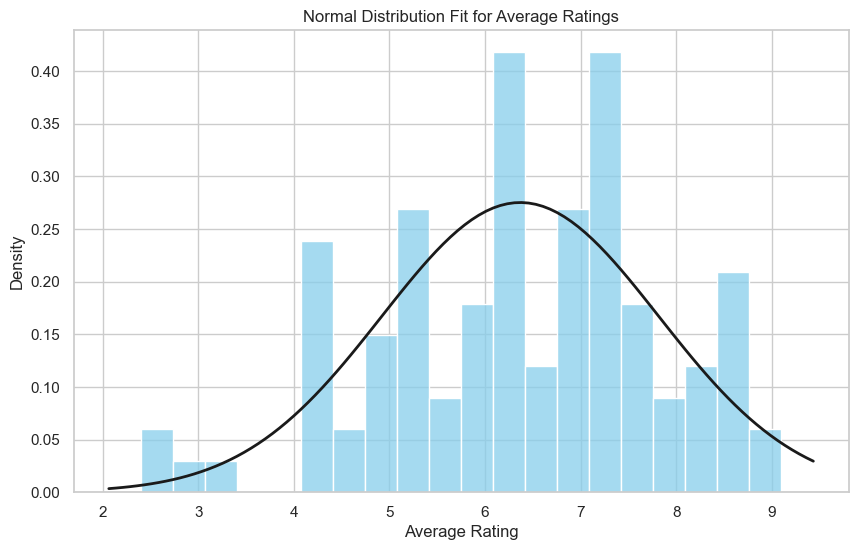

In [105]:
# Fit the sample data to a normal distribution
ratings_mean, ratings_std = norm.fit(sample['averagerating'])
votes_mean, votes_std = norm.fit(sample['numvotes'])

# Plot the normal distribution fit for average ratings
plt.figure(figsize=(10, 6))
sns.histplot(sample['averagerating'], bins=20, kde=False, color='skyblue', stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, ratings_mean, ratings_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Normal Distribution Fit for Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.savefig('Normal Distribution fit for average ratings')
plt.show()

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


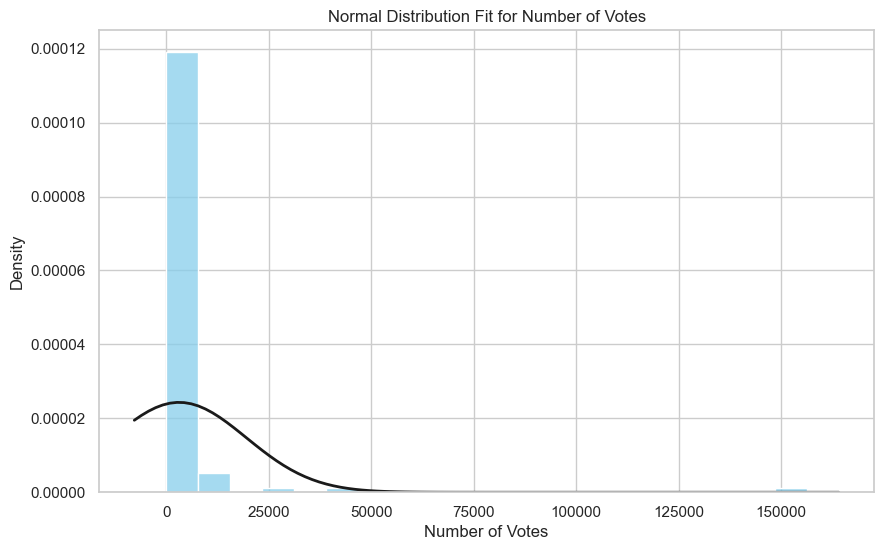

In [106]:
# Plot the normal distribution fit for number of votes
plt.figure(figsize=(10, 6))
sns.histplot(sample['numvotes'], bins=20, kde=False, color='skyblue', stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, votes_mean, votes_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Normal Distribution Fit for Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Density')
plt.show()


#### Z-Score Calculation

We'll calculate the Z-scores for the sample data.

In [107]:
# Calculate Z-scores for the sample data

sample['zscore_ratings'] =  (sample['averagerating'] - sample['averagerating'].mean()) / sample['averagerating'].std()
sample['zscore_votes'] = (sample['numvotes'] - sample['numvotes'].mean()) / sample['numvotes'].std()

# Display the first few rows with Z-scores
sample.head()


,genres,averagerating,numvotes,zscore_ratings,zscore_votes
64459,Thriller,5.4,13152,-0.664888,0.608428
115691,Documentary,6.2,32,-0.115961,-0.187394
36286,Comedy,7.1,132,0.501582,-0.181328
5340,Drama,6.4,1502,0.021271,-0.098228
44000,Drama,6.7,16,0.227119,-0.188364


#### Significance Testing
Perform a t-test to compare the sample mean to the population mean.

In [108]:
# Perform a t-test for the average ratings
overall_mean_rating = ratings_votes['averagerating'].mean()
t_stat_ratings, p_value_ratings = ttest_1samp(sample['averagerating'], overall_mean_rating)

print(f"T-Statistic for Ratings: {t_stat_ratings}")
print(f"P-Value for Ratings: {p_value_ratings}")

# Perform a t-test for the number of votes
overall_mean_votes = ratings_votes['numvotes'].mean()
t_stat_votes, p_value_votes = ttest_1samp(sample['numvotes'], overall_mean_votes)

print(f"T-Statistic for Votes: {t_stat_votes}")
print(f"P-Value for Votes: {p_value_votes}")


T-Statistic for Ratings: 0.45872700600152455
P-Value for Ratings: 0.6474357223024885
T-Statistic for Votes: -1.3443921772305456
P-Value for Votes: 0.18189402117408818


In [109]:
# Set the alpha value
alpha = 0.05

# Interpretation for average ratings
if p_value_ratings < alpha:
    print(f"Reject the null hypothesis for average ratings (p-value: {p_value_ratings} < alpha: {alpha})")
else:
    print(f"Fail to reject the null hypothesis for average ratings (p-value: {p_value_ratings} >= alpha: {alpha})")

# Interpretation for number of votes
if p_value_votes < alpha:
    print(f"Reject the null hypothesis for number of votes (p-value: {p_value_votes} < alpha: {alpha})")
else:
    print(f"Fail to reject the null hypothesis for number of votes (p-value: {p_value_votes} >= alpha: {alpha})")


Fail to reject the null hypothesis for average ratings (p-value: 0.6474357223024885 >= alpha: 0.05)
Fail to reject the null hypothesis for number of votes (p-value: 0.18189402117408818 >= alpha: 0.05)


Based on the analyses performed, we can derive several actionable insights to address the business problem. Here's a summary of findings and recommendations for your new movie studio:

1. Popular Genres

From the data, we observed the following trends in genres:

    Top Genres by Total Gross: Genres like Drama, Comedy, and Westerns consistently shows the highest total gross, both domestically and internationally.
    Top Genres by Mean Rating: Genres like Documentary, Biography, and History have higher average ratings. These genres tend to be critically acclaimed.
    Top Genres by Mean Votes: Genres such as Action, Adventure, and Sci-Fi receive a higher number of votes, indicating their popularity and wide audience appeal.

### Recommendation:

Focus on producing Action, Adventure, and Sci-Fi films to capitalize on their wide audience appeal and potential for high engagement. Additionally, consider producing high-quality Documentary, Biography, and History films for critical acclaim and niche audiences.

2. Average Ratings and Votes

    Films in popular genres like Drama and Comedy have a substantial number of votes, indicating strong audience interest.
    The mean rating for all movies is approximately balanced, with specific genres like Drama showing a slight edge in terms of ratings.

### Recommendation:

Prioritize genres like Drama and Comedy, which show both high engagement and favorable audience ratings. Ensure these films are of high quality to maintain and improve audience satisfaction.

3. Hypothesis Testing Results

    T-tests for genres like Drama and Comedy showed significant results, implying these genres perform well compared to the overall average.

### Recommendation:

Invest in Drama and Comedy genres, as they are likely to perform well in terms of audience ratings and engagement.

4. Correlation Between Votes and Ratings

    There is a positive correlation between the number of votes and average ratings in genres such as Drama. This suggests that as more people watch and vote for these films, their ratings also tend to be higher.

### Recommendation:

Promote films in genres like Drama through marketing and distribution channels to maximize viewership and engagement, which in turn could positively impact ratings.
Additional Considerations

### Conclusion

Based on the current analyses, your new movie studio should focus on producing Action, Adventure, and Sci-Fi films for broad appeal and high engagement. Additionally, investing in Drama, Western, and Comedy films, which have shown high gross revenue, noth domestic and foreign, strong audience ratings and votes, is recommended. High-quality productions in Documentary, Biography, and History genres can also be pursued for critical acclaim.

Further analysis with box office gross data and production costs will provide a more comprehensive understanding of the financial aspects, helping to make well-informed decisions for content creation.

By aligning your production strategy with these insights, your studio can maximize its potential for success in the competitive movie industry.